In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import requests
import re
import string

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [6]:
# Checking if Python evt can see Apple GPU (using MPS Metal Performance Shaders - Metal API)
print("PyTorch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())


PyTorch version: 2.8.0
MPS available: True
MPS built: True


In [7]:
x = torch.randn(1000, 1000, device=device)
y = torch.randn(1000, 1000, device=device)
z = x @ y
print(z.device)

mps:0


In [8]:
a=torch.tensor(10)
print(a)
print(a.device)

tensor(10)
cpu


## Import text and create dict

In [9]:
# get raw text fro, internet (Time Machine)

text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text
# chara string to replace with space
strings2replace = [ '\r\n\r\n\â\x90\x9c', 'â\x80\x9c', 'â\x80\x9d', '\r\n','â\x80\x94']
# use reg exp to replace those stings with space
for str2match in strings2replace:
    text = re.compile(r'%s'%str2match).sub(' ',text)

#remove non ascii char and numbers and make lower case
text = re.sub(r'[^\x00-\x7F]+',' ',text)
text = re.sub('\d+', '',text).lower()

#split into words with >1 letter
words = re.split(f'[{string.punctuation}\s]+',text)
words = [item.strip() for item in words if item.strip()]
words = [item for item in words if len(item)>1]

# create vocab 
vocab = sorted(set(words))
nWords = len(words)
nVocab = len(vocab)

# encode/decoder look up tables 
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}

print(f'The book contains {nWords} words, {nVocab} of which are unique')
print(f'\n\nFirst 10 vocab words:\n',list(word2idx.keys())[:10]) 

The book contains 30698 words, 4589 of which are unique


First 10 vocab words:
 ['abandon', 'abandoned', 'able', 'abnormally', 'abominable', 'abominations', 'about', 'above', 'abruptly', 'absence']


In [10]:
text

'*** start of the project gutenberg ebook  ***     the time machine  an invention  by h. g. wells   contents   i introduction  ii the machine  iii the time traveller returns  iv time travelling  v in the golden age  vi the sunset of mankind  vii a sudden shock  viii explanation  ix the morlocks  x when night came  xi the palace of green porcelain  xii in the darkness  xiii the trap of the white sphinx  xiv the further vision  xv the time traveller s return  xvi after the story  epilogue      i.  introduction   the time traveller (for so it will be convenient to speak of him) was expounding a recondite matter to us. his pale grey eyes shone and twinkled, and his usually pale face was flushed and animated. the fire burnt brightly, and the soft radiance of the incandescent lights in the lilies of silver caught the bubbles that flashed and passed in our glasses. our chairs, being his patents, embraced and caressed us rather than submitted to be sat upon, and there was that luxurious after-

In [11]:
words

['start',
 'of',
 'the',
 'project',
 'gutenberg',
 'ebook',
 'the',
 'time',
 'machine',
 'an',
 'invention',
 'by',
 'wells',
 'contents',
 'introduction',
 'ii',
 'the',
 'machine',
 'iii',
 'the',
 'time',
 'traveller',
 'returns',
 'iv',
 'time',
 'travelling',
 'in',
 'the',
 'golden',
 'age',
 'vi',
 'the',
 'sunset',
 'of',
 'mankind',
 'vii',
 'sudden',
 'shock',
 'viii',
 'explanation',
 'ix',
 'the',
 'morlocks',
 'when',
 'night',
 'came',
 'xi',
 'the',
 'palace',
 'of',
 'green',
 'porcelain',
 'xii',
 'in',
 'the',
 'darkness',
 'xiii',
 'the',
 'trap',
 'of',
 'the',
 'white',
 'sphinx',
 'xiv',
 'the',
 'further',
 'vision',
 'xv',
 'the',
 'time',
 'traveller',
 'return',
 'xvi',
 'after',
 'the',
 'story',
 'epilogue',
 'introduction',
 'the',
 'time',
 'traveller',
 'for',
 'so',
 'it',
 'will',
 'be',
 'convenient',
 'to',
 'speak',
 'of',
 'him',
 'was',
 'expounding',
 'recondite',
 'matter',
 'to',
 'us',
 'his',
 'pale',
 'grey',
 'eyes',
 'shone',
 'and',
 'tw

## Define the para of dataset

In [12]:
# parameters of dataset
context_length = 8 # context length(seq lenght)
stride = 2

#initalize
inputs = []
targets = []

#overlapping seq of context_length
for i in range(0,nWords-context_length, stride):
    # get a few words
    in_seq = words[i:i+context_length]
    targ_seq = words[i+1:i+context_length+1]

    #append to lists
    inputs.append([word2idx[w] for w in in_seq])
    targets.append([word2idx[w] for w in targ_seq])
len(inputs)

15345

In [13]:
print(inputs[123])
print(targets[123])

[1342, 4304, 4119, 342, 4296, 3388, 1474, 131]
[4304, 4119, 342, 4296, 3388, 1474, 131, 209]


In [14]:
print(inputs[124])
print(targets[124])

[4119, 342, 4296, 3388, 1474, 131, 209, 2907]
[342, 4296, 3388, 1474, 131, 209, 2907, 4510]


In [15]:
# we need the above in a different format in torch Dataset/DataLoader format

# We need each list to be a tensor
torch.tensor(inputs[123])

tensor([1342, 4304, 4119,  342, 4296, 3388, 1474,  131])

In [16]:
len(text)

179773

## Create a class for a dataset object

In [17]:
print(len(words))
print('\n\n', words)

30698


 ['start', 'of', 'the', 'project', 'gutenberg', 'ebook', 'the', 'time', 'machine', 'an', 'invention', 'by', 'wells', 'contents', 'introduction', 'ii', 'the', 'machine', 'iii', 'the', 'time', 'traveller', 'returns', 'iv', 'time', 'travelling', 'in', 'the', 'golden', 'age', 'vi', 'the', 'sunset', 'of', 'mankind', 'vii', 'sudden', 'shock', 'viii', 'explanation', 'ix', 'the', 'morlocks', 'when', 'night', 'came', 'xi', 'the', 'palace', 'of', 'green', 'porcelain', 'xii', 'in', 'the', 'darkness', 'xiii', 'the', 'trap', 'of', 'the', 'white', 'sphinx', 'xiv', 'the', 'further', 'vision', 'xv', 'the', 'time', 'traveller', 'return', 'xvi', 'after', 'the', 'story', 'epilogue', 'introduction', 'the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him', 'was', 'expounding', 'recondite', 'matter', 'to', 'us', 'his', 'pale', 'grey', 'eyes', 'shone', 'and', 'twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the', 

In [18]:
class WordDataset(Dataset):
    def __init__(self, text, word2idx, context_length=8, stride=4):

        # init
        self.inputs = []
        self.targets = []
        self.word2idx = word2idx #stored locally in the object

        # overlapping seq of context_length
        for i in range(0,len(text)-context_length,stride):
            #get a few words
            in_seq = text[i:i+context_length]
            targ_seq = text[i+1:i+context_length+1]

            # append to lists
            self.inputs.append(torch.tensor([word2idx[w] for w in in_seq]))
            self.targets.append(torch.tensor([word2idx[w] for w in targ_seq]))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,idx):
        return self.inputs[idx], self.targets[idx]


# ceate an instance
context_length = 6
stride = 3
text_dataset = WordDataset(words, word2idx, context_length, stride)

print(text_dataset[4])
print('\n\n', text_dataset[5])

(tensor([4451,  783, 2167, 2005, 4042, 2416]), tensor([ 783, 2167, 2005, 4042, 2416, 2006]))


 (tensor([2005, 4042, 2416, 2006, 4042, 4109]), tensor([4042, 2416, 2006, 4042, 4109, 4171]))


In [19]:
# Create a DataLoader for training
dataloader = DataLoader(text_dataset, 
                        batch_size = 32, # 2 for looking: 32 for training 
                        shuffle = True,
                        drop_last = True
                       )

# have a look at the indices
X,y = next(iter(dataloader))
print('Inputs:')
print(X), print('')

print('Targets:')
print(y), print('\n\n\n')

# and the words
print('Inputs in words (First batch):')
print([idx2word[item.item()] for item in X[0]])
print('')

print('Targets in words (First batch):')
print([idx2word[item.item()] for item in y[0]])

# and the words
print('\n\n\nInputs in words (Second batch):')
print([idx2word[item.item()] for item in X[1]])
print('')

print('Targets in words (Second batch):')
print([idx2word[item.item()] for item in y[1]])

Inputs:
tensor([[ 522, 3415, 2010, 4458,  959,  137],
        [4576,  709, 4119, 4066, 2186, 2183],
        [2608, 2172, 1815, 4325, 4576, 1572],
        [4408, 3905, 4051, 4454, 4086,  643],
        [ 823, 3207, 2387, 2569,  879,  137],
        [ 863, 1878,  124, 4466, 4454, 4059],
        [2726, 4133, 1971, 3754,  519, 4119],
        [2041, 4466, 1035, 3748, 2572, 3534],
        [1981, 1977, 2337, 1815, 2382, 3608],
        [2731, 3712, 4352, 1843, 4478, 2500],
        [2608, 2812, 2045, 4119, 1368, 2187],
        [2825, 2433, 1679, 2740, 4042, 3987],
        [4225, 4042, 2198, 3933,  332, 3860],
        [4461,  519, 2041, 3587, 2731, 4042],
        [ 602, 3144, 4041, 1984, 1640, 4042],
        [ 137, 2777, 4510, 4264,  434,  137],
        [4408,  102, 4042, 4109, 1036,  501],
        [2041, 4042, 1198, 3628, 2347, 4042],
        [ 158,  137,  368, 4445, 4408, 4117],
        [2470, 1704, 4047, 1453, 3584, 1572],
        [1791, 3711, 1773, 4042, 3628,  706],
        [2731, 4042, 2822,

In [20]:
type(X)

torch.Tensor

## Build a model to learn the embeddings

In [21]:
# create and explore an embedding layer

embeddingDimension = 100

#create a random embedding
embedding_layer = nn.Embedding(nVocab, embeddingDimension)

#see its size
embedding_layer.weight.shape

torch.Size([4589, 100])

In [22]:
# the embedding_layer is initialised randomly
# Every time a token passes through the model:

#    1.The embedding for that token is selected from the table.

#    2.The model predicts something.

#    3.Loss is computed.

#    4.Gradients update only the rows corresponding to the tokens used.

In [23]:
embedding_layer.weight

Parameter containing:
tensor([[-0.3058,  0.1406,  0.0363,  ..., -1.1115,  0.3792, -0.1822],
        [ 0.5080,  0.1011,  0.0083,  ...,  0.0365, -0.1616,  0.2036],
        [-1.4617,  0.4810,  0.8828,  ..., -0.3797,  0.4491,  1.3453],
        ...,
        [-0.7026,  1.5496, -1.7077,  ..., -0.3242,  1.5029, -1.2718],
        [-0.1869,  1.9645, -0.9366,  ...,  0.0757, -0.7883,  0.3152],
        [-0.8445, -1.0333, -1.3621,  ...,  1.2258, -0.1464,  1.6807]],
       requires_grad=True)

In [24]:
embedding_layer

Embedding(4589, 100)

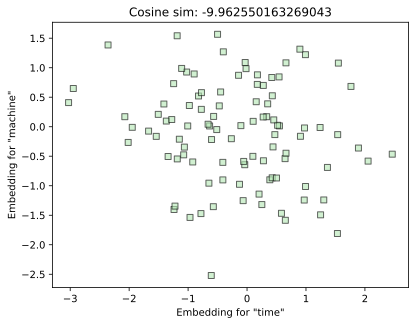

In [25]:
# embeddings for closely related words
word1 = 'time'
word2 = 'machine'

#their embeddings
embed1 = embedding_layer.weight.detach()[word2idx[word1],:]
embed2 = embedding_layer.weight.detach()[word2idx[word2],:]

#cosine sim btw them
cosSim = torch.dot(embed1,embed2)/torch.norm(embed1)*torch.norm(embed2)

plt.plot(embed1,embed2,'ks',markerfacecolor=[.7,.9,.7],alpha=.6)
plt.gca().set(xlabel=f'Embedding for "{word1}"', ylabel = f'Embedding for "{word2}"',
              title = f'Cosine sim: {cosSim}')
plt.show()


In [26]:
# Build the model

class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(EmbeddingModel, self).__init__()

        # embedding layer
        self.embeddings = nn.Embedding(vocab_size,embedding_dim) #4589x100

        #linear hidden layers
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) #600x128
        self.linear2 = nn.Linear(128, vocab_size) #128*4589

    def forward(self, inputs):
        # the fwd pass process the current token to predict next token
        
        # extract and flatten embeddings, reshapes to [batch_size, context_size * embedding_dim]
        embeds = self.embeddings(inputs).view(inputs.shape[0],-1)

        #fully connected layers
        out = F.relu(self.linear1(embeds)) #connecting to first H.L
        out = self.linear2(out)

        #log softmax for classfcn ( NLLLoss expects logprobs as inputs)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

# create a model instance
model = EmbeddingModel(vocab_size=nVocab, embedding_dim=embeddingDimension, context_size=context_length)
print(model)



# apply Xavier normlsn on initialise weights, so that Std deviation of weights is tighter
# helps in training
for param in model.parameters():
    if param.dim()>1: #also exlcudes biases
        nn.init.xavier_normal_(param)

EmbeddingModel(
  (embeddings): Embedding(4589, 100)
  (linear1): Linear(in_features=600, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=4589, bias=True)
)


In [27]:
#lets test the model

X,y = next(iter(dataloader))
modelOut = model(X)

print('input to model:')
print(X), print('')

print(f'Output from model (size: {list(modelOut.detach().shape)}):')
print(modelOut)

input to model:
tensor([[4408, 4133, 1953, 2387,  255, 2368],
        [ 137, 4047, 2375,  709, 1122,  137],
        [4408, 3618, 2740, 3699, 4215, 2041],
        [4450, 2186, 4408, 2685, 1572, 3712],
        [ 584, 2731,  329, 1541,  110, 2653],
        [4189, 2791, 2625,  501, 4189, 2791],
        [4458, 3465, 2471, 4042, 2572,  255],
        [ 408, 3209, 4419,  137, 2186, 4408],
        [1815,  709, 4516,  215, 4516, 2482],
        [4100,  340, 4041,  137, 3693, 1590],
        [1385, 4042, 2368, 1835, 4296, 4042],
        [1133,  137,  360,  137, 2548, 2731],
        [2186, 2041, 2578,  137, 3116, 4057],
        [2903,  137, 1118, 2741, 2764, 4223],
        [2440, 4450, 1104, 2685, 2518, 4013],
        [ 137, 4051, 4408, 4041, 2413,   71],
        [ 179,  839, 4144, 2470, 1453, 4102],
        [4109, 4408, 4051, 1537, 4064, 2041],
        [2722, 4119, 2470,   74,  137,   74],
        [4051, 3465, 4119,  319, 1461, 2003],
        [4466, 2897, 3432, 2764, 3693, 2731],
        [4296, 404

In [28]:
y

tensor([[4133, 1953, 2387,  255, 2368, 4445],
        [4047, 2375,  709, 1122,  137, 1351],
        [3618, 2740, 3699, 4215, 2041, 1641],
        [2186, 4408, 2685, 1572, 3712, 4109],
        [2731,  329, 1541,  110, 2653, 4119],
        [2791, 2625,  501, 4189, 2791, 2625],
        [3465, 2471, 4042, 2572,  255,  162],
        [3209, 4419,  137, 2186, 4408, 1950],
        [ 709, 4516,  215, 4516, 2482, 4516],
        [ 340, 4041,  137, 3693, 1590, 3491],
        [4042, 2368, 1835, 4296, 4042, 1018],
        [ 137,  360,  137, 2548, 2731,  800],
        [2041, 2578,  137, 3116, 4057, 2041],
        [ 137, 1118, 2741, 2764, 4223, 1815],
        [4450, 1104, 2685, 2518, 4013, 4581],
        [4051, 4408, 4041, 2413,   71, 1048],
        [ 839, 4144, 2470, 1453, 4102, 2740],
        [4408, 4051, 1537, 4064, 2041, 4086],
        [4119, 2470,   74,  137,   74, 4467],
        [3465, 4119,  319, 1461, 2003,  162],
        [2897, 3432, 2764, 3693, 2731, 4042],
        [4042, 3587, 2731, 4042, 2

In [29]:
len(modelOut[0])

4589

In [30]:
X[0]

tensor([4408, 4133, 1953, 2387,  255, 2368])

In [31]:
# the 2X4589 matrix in above output
# each row is the logsoftmax value for every possible word in the vocab to 
# be predicted as the final token in the seq

In [32]:
# log softmax output:
print(modelOut.detach()[0])
print('')

#shouldnt the sum be 1 ??
print(f'Log softmax sum = {modelOut.detach()[0].sum()}')

#ah its *log* softmax :D
print(f'exp(log(softmax) sum = {torch.exp(modelOut.detach()[0]).sum()}')

tensor([-8.3681, -8.3455, -8.4062,  ..., -8.4825, -8.4926, -8.4021])

Log softmax sum = -38697.72265625
exp(log(softmax) sum = 1.000000238418579


In [33]:
# find word with highest prob
print('Model input:')
print([idx2word[w.item()] for w in X[0]])
print('')

print('Model output:')
print(idx2word[modelOut[0].argmax().item()])

Model input:
['was', 'too', 'horrible', 'looked', 'at', 'little']

Model output:
halitus


In [34]:
# have the model generate text

# grab some data from loader
X,y = next(iter(dataloader))

print('First input:')
print(' '.join([idx2word[w.item()] for w in X[0]]))
print('\nsubsequent inputs:')

# text generation
for _ in range(context_length):
    # get output for this input
    Y = model(X)

    #pick the most liekely next word
    nextWord = Y[0].argmax().item()

    #create new input for next iteration (word)
    X[0] = torch.concatenate((X[0][1:], torch.tensor([nextWord])))

    # print out generated text so far
    print(' '.join([idx2word[w.item()] for w in X[0]]))
    

First input:
perforce sharer in their degradation and

subsequent inputs:
sharer in their degradation and especially
in their degradation and especially abominations
their degradation and especially abominations within
degradation and especially abominations within minutes
and especially abominations within minutes weakness
especially abominations within minutes weakness weakness


In [35]:
' '.join([idx2word[w.item()] for w in y[0]])

'sharer in their degradation and their'

In [36]:
# summary of the model

summary(model,input_data = X, col_names=['input_size', 'output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
EmbeddingModel                           [32, 6]                   [32, 4589]                --
├─Embedding: 1-1                         [32, 6]                   [32, 6, 100]              458,900
├─Linear: 1-2                            [32, 600]                 [32, 128]                 76,928
├─Linear: 1-3                            [32, 128]                 [32, 4589]                591,981
Total params: 1,127,809
Trainable params: 1,127,809
Non-trainable params: 0
Total mult-adds (M): 36.09
Input size (MB): 0.00
Forward/backward pass size (MB): 1.36
Params size (MB): 4.51
Estimated Total Size (MB): 5.87

![alt text for screen readers](./code_arch_mapping.png) 

## Loss function to train the embeddings

In [37]:
# refer to notebook: embed_LossFunction

## Train and evaluate model

In [38]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [40]:
# create a fresh instance of model
model = EmbeddingModel(vocab_size=nVocab, embedding_dim=embeddingDimension, context_size=context_length)

# with Xavier weight disbn
for param in model.parameters():
    if param.dim()>1: #also exlcudes biases
        nn.init.xavier_normal_(param)

#move the model to GPU
model = model.to(device)

In [41]:
# creae loss and optimizer func
loss_function = nn.NLLLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=.001, weight_decay=.01)

In [46]:
# quick test for errors and sanity check the output matrix sizes
X,y = next(iter(dataloader))
X,y = X.to(device), y.to(device)

# fwd pass
modelOutput = model(X)

# check the sizes
print(f'Model input is of size: {X.shape}') #IRL, we train on 1000s of seq length, here only 6
print(f'Target output is of size: {y.shape}')
print(f'Model output is of size: {modelOutput.shape}') # log softmax prob for all 4500 tokens for 
# each of the final token in the seq

# loss func
loss = loss_function(modelOutput,y[:,-1])  # loss is based on the last token of a sequence
print(f'\nLoss: {loss}')

Model input is of size: torch.Size([32, 6])
Target output is of size: torch.Size([32, 6])
Model output is of size: torch.Size([32, 4589])

Loss: 8.433623313903809


In [47]:
X

tensor([[4111,  137, 1971, 4488, 4042, 2157],
        [ 714,   71, 2470, 4510, 4041, 2387],
        [2698, 2435, 2183, 1419, 2317, 1072],
        [ 373, 4042, 3154, 2731, 2608, 1360],
        [4042, 3627,  137, 4042, 4297,  430],
        [3116, 2186, 1122,  137, 4047, 2186],
        [2339, 3761,  255, 4042, 1487, 4047],
        [4249, 4042, 3803,  137, 1591, 1086],
        [ 477, 1175, 2731,  972, 2955, 4041],
        [1125, 4454, 2008,  255, 1492, 4428],
        [ 482, 4041, 1516,  137, 2857, 2041],
        [  96, 3330, 2041, 2528, 1868, 3116],
        [1719,  137, 2850, 4265,   53, 4017],
        [ 457, 3699,  704, 3347,  137, 3540],
        [2500, 2259, 4510, 4458, 3465, 2471],
        [4042, 4109, 4171, 2186, 4549,  319],
        [2163, 4042, 4529, 2698, 1769,  137],
        [3840, 4051, 2041, 4042, 1674,  902],
        [1226, 2041, 4466, 4428,  204,  255],
        [ 410,  828,  188, 4178, 4144, 2470],
        [2426, 3302, 4042, 4109, 4171, 4047],
        [ 549, 4351,  255, 4042, 3

In [48]:
y

tensor([[ 137, 1971, 4488, 4042, 2157,  371],
        [  71, 2470, 4510, 4041, 2387, 1572],
        [2435, 2183, 1419, 2317, 1072,  137],
        [4042, 3154, 2731, 2608, 1360, 4073],
        [3627,  137, 4042, 4297,  430, 2287],
        [2186, 1122,  137, 4047, 2186,  519],
        [3761,  255, 4042, 1487, 4047, 1868],
        [4042, 3803,  137, 1591, 1086, 4042],
        [1175, 2731,  972, 2955, 4041, 4408],
        [4454, 2008,  255, 1492, 4428, 1714],
        [4041, 1516,  137, 2857, 2041, 2780],
        [3330, 2041, 2528, 1868, 3116, 1122],
        [ 137, 2850, 4265,   53, 4017, 2339],
        [3699,  704, 3347,  137, 3540, 4478],
        [2259, 4510, 4458, 3465, 2471, 4042],
        [4109, 4171, 2186, 4549,  319, 3247],
        [4042, 4529, 2698, 1769,  137, 2966],
        [4051, 2041, 4042, 1674,  902, 4077],
        [2041, 4466, 4428,  204,  255, 3027],
        [ 828,  188, 4178, 4144, 2470, 4219],
        [3302, 4042, 4109, 4171, 4047, 4461],
        [4351,  255, 4042, 3583, 4

In [57]:
y[:,-1]

tensor([ 371, 1572,  137, 4073, 2287,  519, 1868, 4042, 4408, 1714, 2780, 1122,
        2339, 4478, 4042, 3247, 2966, 4077, 3027, 4219, 4461, 3776,  137,  137,
         280, 3459, 1929, 4249,   34, 4042, 3468,  137], device='mps:0')

In [52]:
modelOutput[0]

tensor([-8.3811, -8.3527, -8.4859,  ..., -8.3763, -8.3671, -8.5024],
       device='mps:0', grad_fn=<SelectBackward0>)

In [55]:
# Extract the pretrained embedding weights for comparison later
pretrained_embeddings = model.embeddings.weight.detach().cpu()
pretrained_embeddings.shape

torch.Size([4589, 100])

 ## Now train the model

In [58]:
def trainTheModel(model, num_epochs=25):
    #init the losses
    total_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):

        #initialize
        epoch_loss = 0

        # loop over batches in data loader
        for X,y in dataloader:

            # move data to GPU
            X,y = X.to(device), y.to(device)

            # clear previous grads
            model.zero_grad()

            # fwd pass
            log_probs = model(X)

            # calculate losses from final target word
            loss = loss_function(log_probs, y[:,-1])

            #backprop
            loss.backward()
            optimizer.step()

            # sum the per epoch losses
            epoch_loss += loss.item()

        # scale by num of tokens in this dataloader
        total_loss[epoch] = epoch_loss/ len(dataloader.dataset)

        print(f' Finished epoch {epoch+1} with loss {epoch_loss/ len(dataloader.dataset)}')

    return model, total_loss
            
        
    

In [59]:
# train the model

model, total_loss = trainTheModel(model)


 Finished epoch 1 with loss 0.21731123585421813
 Finished epoch 2 with loss 0.18766794068619205
 Finished epoch 3 with loss 0.17482371540459216
 Finished epoch 4 with loss 0.16372096066646893
 Finished epoch 5 with loss 0.15321449170351703
 Finished epoch 6 with loss 0.1421500812724776
 Finished epoch 7 with loss 0.13021894524773478
 Finished epoch 8 with loss 0.11634935559957052
 Finished epoch 9 with loss 0.10059441442119564
 Finished epoch 10 with loss 0.082927765600167
 Finished epoch 11 with loss 0.06384005993764871
 Finished epoch 12 with loss 0.04470296158793851
 Finished epoch 13 with loss 0.027578351053368044
 Finished epoch 14 with loss 0.015497798712742246
 Finished epoch 15 with loss 0.008337729143794593
 Finished epoch 16 with loss 0.004449426719297844
 Finished epoch 17 with loss 0.0025077277089730118
 Finished epoch 18 with loss 0.0015210840649347176
 Finished epoch 19 with loss 0.0009584844384756434
 Finished epoch 20 with loss 0.0007118644326081981
 Finished epoch 21 w

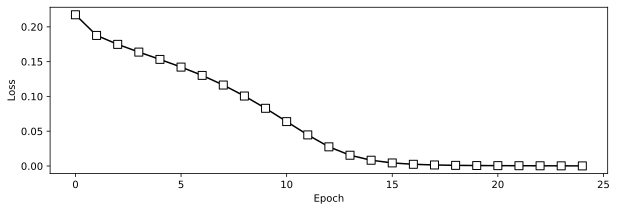

In [60]:

#plot losses
plt.figure(figsize=(10,3))
plt.plot(total_loss,'ks-', markerfacecolor='w', markersize=8)
plt.gca().set(xlabel='Epoch', ylabel='Loss')
plt.show()

In [61]:
# get trained weights
postrained_embeddings=model.embeddings.weight.detach().cpu()